# JSL49_01 (CF-900)

In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [15]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
from IPython.core.display import display, HTML
import mjsplot as mplt

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename): # a way to load in many different files and keep track of them. 
    datafile = json.loads( codecs.open('../data/'+filename,'r','utf-8').read() )
    key = datafile['attr']['_file counter']
    d[key]= datafile
    df[key] = pd.DataFrame(datafile['data']) 

# Find best match
def find_nu(Bsdh):
    nu = np.linspace(20,1,20)
    Bnu = Phi_0/nu
    Bnu_diff = [t/s for s, t in zip(Bnu, Bnu[1:])]
    Bsdh_diff = np.array([t/s for s, t in zip(Bsdh, Bsdh[1:])])
    size_part = len(Bsdh_diff)
    residuals = [np.sum(Bnu_diff[i:i+size_part]-Bsdh_diff) for i in range(len(Bnu_diff)-size_part+1)]
    idx = np.argmin(np.abs(residuals))
    return nu[idx:idx+len(Bsdh)]

# Hallbar 1

## Density and mobility

## Raw data at Vgate = 0

Density and mobility from Rxy:
n = 3.49e+12 cm^-2
mu = 12324 cm^-2/Vs


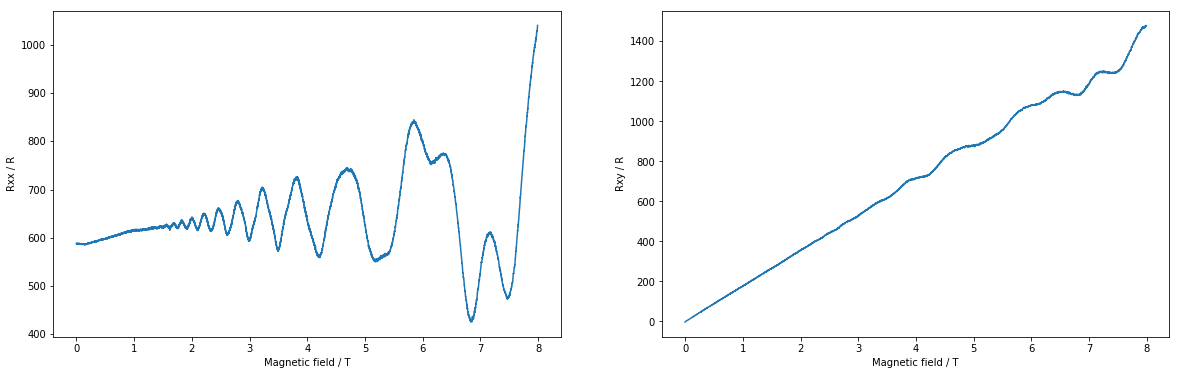

In [147]:
## Load data
loadin("20180625T120910889Z-0009.json")

Rxx = (df['0009']['DC Voltage xx / V'][:9466]+0.0840319348*1e-3)/1e-7
Rxy = (df['0009']['DC Voltage xy / V'][:9466]+0.0849385834*1e-3)/1e-7
Bmeas = df['0009']['Measured Field / T'][:9466]

rho = 581/4

## Plot
fig_1b, ax_1b = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
for ax,plot,ylbl in zip(ax_1b,[(Bmeas,Rxx),(Bmeas,Rxy)],['Rxx / R','Rxy / R']):
    ax.plot(*plot)
    ax.set_xlabel('Magnetic field / T')
    ax.set_ylabel(ylbl)
    
# Save figure
plt.savefig('../plots/hallbar1_rxx_rxy.png')

## Overal density and mobility
n_total = 1/179/e ## Rxy slope
mu_total = 1/(rho*n_total*1e-4*e)
print('Density and mobility from Rxy:\nn = {0:.2e} '.format(n_total*1e-4)+'cm^-2')
print('mu'+' = {0:.0f} '.format(mu_total)+'cm^-2/Vs')

Total density and mobility:
n = 3.49e+16 cm$^{-2}$
${\mu}$ = 12324 cm$^{-2}$/Vs


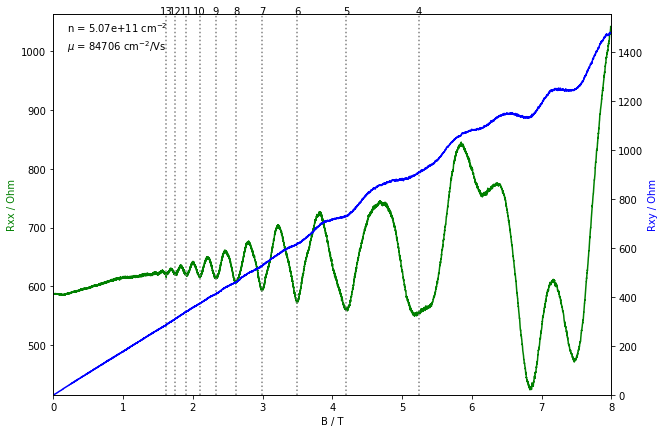

In [134]:
## Filling factors
# B_extra = [6.89277944]
Bsdh = np.array([1.62,1.75,1.91,2.1,2.33,2.62,3,3.5,4.2,5.2]) # Shubnikov- de Haas minima from Rxy

# Find best matching filling factors
nu = find_nu(Bsdh)
n = np.mean(Bsdh*nu/Phi_0)*1e-4
mu = 1/(rho * n * e)
B_nu = n*1e4*Phi_0/nu

## Make overview plot
fig_1c, ax_1c = plt.subplots(figsize=(10,7))
xmax = [min(Rxx)*0.98,0]
ymax = [max(Rxx)*1.02,max(Rxy)*1.05]
for ax,ylims,f,color,label in zip([ax_1c,ax_1c.twinx()],
                    [(xmax[0],ymax[0]),(xmax[1],ymax[1])],
                    [Rxx,Rxy],['green','blue'],
                    ['Rxx / Ohm','Rxy / Ohm']):
    ax.set_xlim(0,8)
    ax.set_ylim(*ylims)
    ax.plot(Bmeas,f,color=color)
    ax.set_xlabel('B / T')
    ax.set_ylabel(label,color=color)

# Density and mobility annotation
ax_1c.annotate('n = {0:.2e} '.format(n)+u'cm$^{-2}$',(0.2,ymax[0]-30))
ax_1c.annotate(u'${\mu}$'+' = {0:.0f} '.format(mu)+u'cm$^{-2}$/Vs',(0.2,ymax[0]-60))

# Filling factors
for xc,nuc in zip(B_nu,nu):
    ax_1c.axvline(x=xc,color='gray',ls=':')
    ax_1c.annotate('{0:.0f}'.format(nuc),(xc,ymax[0]),ha="center")
    
# Save figure
fig_1c.savefig('../plots/hallbar1_subband1.png')
# print("n = {0}, mu = {1}".format(n*1e-4,mu))

## Magnetic field up to 9T with topgate

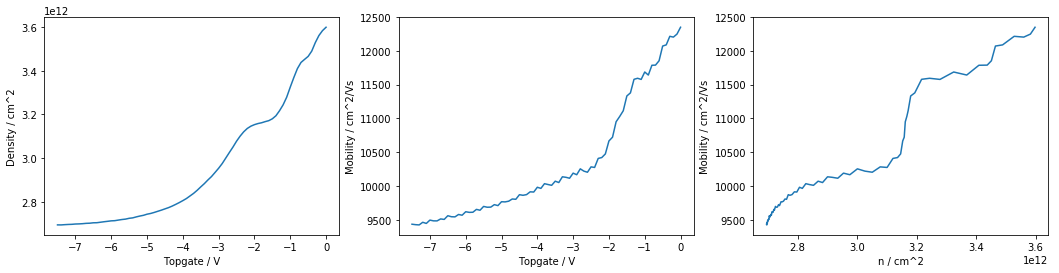

In [153]:
## Load data (not corrected for geometry)
loadin("20180626T145647604Z-0033.json")

# Get density
r_df_1  = pd.DataFrame()
dc_current = 1e-7
for label,group in df['0033'].groupby('Topgate Voltage / V'):
    [b,a] = np.polyfit(group['Magnet Z / T'],group['DC Voltage xy / V']/dc_current,1)
    Vxx = group[group['Magnet Z / T'] == 0.]['DC Voltage xx / V'].values[0]+8.6134e-5
    r_df_1 = r_df_1.append({'a':a,'b':b,'n':1/(e*b)*1e-4,'v':label,'Vxx':Vxx},ignore_index=True)
# Get mobility
r_df_1['rho'] = r_df_1['Vxx']/(dc_current * 4) # Mesa contains 4 squares
r_df_1['mu'] = 1/(r_df_1['rho']*r_df_1['n']*e)

## Plot
fig_1a, ax_1a = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

subplots_1a = [(r_df_1['v'],r_df_1['n']),(r_df_1['v'],r_df_1['mu']),(r_df_1['n'],r_df_1['mu'])]
labels_1a = [['Topgate / V','Density / cm^2'],['Topgate / V', 'Mobility / cm^2/Vs'], ['n / cm^2','Mobility / cm^2/Vs']]

for col,subplot,label in zip(ax_1a,subplots_1a,labels_1a):
    col.plot(*subplot)
    col.set_xlabel(label[0])
    col.set_ylabel(label[1])

# Save figure
fig_1a.savefig('../plots/hallbar1_mobilty_density.png')

## Track individual subbands with gate

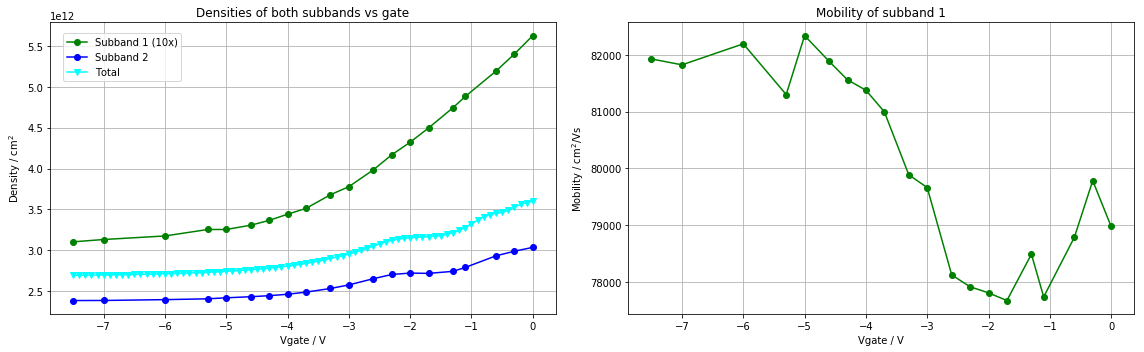

In [173]:
Bsdh_all = {}
Bsdh_all[0] = [1.94,2.13,2.33,2.58,2.91,3.3]
Bsdh_all[-0.3] = [2.03,2.23,2.5,2.78,3.2,3.71] 
Bsdh_all[-.6] = [2.15,2.4,2.67,3.07,3.57] 
Bsdh_all[-1.1] = [2.02,2.25,2.5,2.89,3.38] 
Bsdh_all[-1.3] = [1.98,2.18,2.45,2.8,3.25] 
Bsdh_all[-1.7] = [1.86,2.07,2.3,2.67,3.11] 
Bsdh_all[-2] = [1.79,1.99,2.23,2.55,2.98]
Bsdh_all[-2.3] = [1.91,2.15,2.45,2.9,3.45] 
Bsdh_all[-2.6] = [1.67,1.83,2.05,2.34,2.74] 
Bsdh_all[-3] = [1.73,1.97,2.25,2.6,3.09] 
Bsdh_all[-3.3] = [1.52,1.7,1.92,2.15,2.53] 
Bsdh_all[-3.7] = [1.46,1.6,1.82,2.07,2.43] 
Bsdh_all[-4] = [1.43,1.57,1.78,2.03,2.38] 
Bsdh_all[-4.3] = [1.54,1.74,2,2.32,2.78]
Bsdh_all[-4.6] = [1.52,1.71,1.95,2.27,2.75]
Bsdh_all[-5] = [1.5,1.69,1.92,2.24,2.68]
Bsdh_all[-5.3] = [1.5,1.69,1.92,2.24,2.68]
Bsdh_all[-6] = [1.45,1.65,1.88,2.2,2.61]
Bsdh_all[-7] = [1.63,1.84,2.17,2.58,3.23]
Bsdh_all[-7.499999999999999] = [1.44,1.6,1.83,2.15,2.54] 

# Get density from Rxx data (single channel)
n_band1, mu_band1, nu_band1 = [],[],[]
for vgate,Bsdh in Bsdh_all.items():
    # Find best matching filling factors
    nu = find_nu(Bsdh)
    n = np.mean(Bsdh*nu/Phi_0)*1e-4 
    mu = 1/(r_df_1[r_df_1['v'] == vgate]['rho'].values[0] * n * e)
    nu_band1.append(nu)
    n_band1.append(n)
    mu_band1.append(mu)
    
# Get densities from Rxy data (all channels combined) 
v_tot = [r_df_1[r_df_1['v'] == vgate]['v'].values[0] for vgate,_ in Bsdh_all.items()]  
n_tot = [r_df_1[r_df_1['v'] == vgate]['n'].values[0] for vgate,_ in Bsdh_all.items()]

# Plot both channels as a function of gate
fig_1d, ax_1d = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
for axes,plot,label,ls,color,ylabel,title in zip(
                                     [ax_1d[0],ax_1d[0],ax_1d[0],ax_1d[1]],
                                     [([vgate for vgate,_ in Bsdh_all.items()], np.array(n_band1)*10),
                                      (v_tot, np.array(n_tot)-np.array(n_band1)),
                                      (r_df_1['v'], r_df_1['n']),
                                      ([vgate for vgate,_ in Bsdh_all.items()],mu_band1)],
                                     ['Subband 1 (10x)','Subband 2','Total',''],
                                     ['o-','o-','v-','o-'],
                                     ['green','blue','cyan','green'],
                                     [u'Density / cm$^{2}$']*3+[u'Mobility / cm$^{2}$/Vs'],
                                     ['Densities of both subbands vs gate']*3+['Mobility of subband 1']):
    axes.plot(*plot,ls,label=label,color=color)
    axes.set_xlabel('Vgate / V')
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.grid(which='major')
fig_1d.legend(loc='upper left', bbox_to_anchor=(0.05,0.9))
fig_1d.tight_layout()

# Save figure
fig_1d.savefig('../plots/hallbar1_subbands.png')

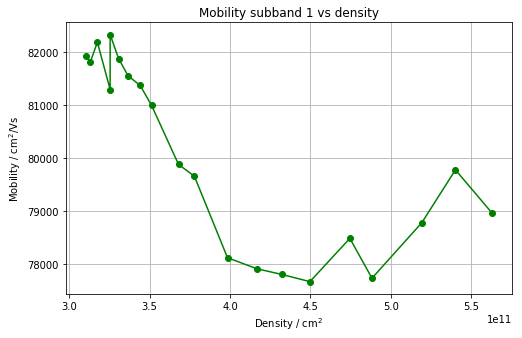

In [174]:
fig_1e, ax_1e = plt.subplots(figsize=(8,5))
ax_1e.plot(n_band1,mu_band1,'o-',color='green')
ax_1e.set_xlabel(u'Density / cm$^{2}$')
ax_1e.set_ylabel(u'Mobility / cm$^{2}$/Vs')
ax_1e.set_title('Mobility subband 1 vs density')
ax_1e.grid(which='major')

# Save figure
fig_1e.savefig('../plots/hallbar1_subband1_mobility_vs_density.png')

## Processed Vxy data

In [171]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/dbouman1/2deg/master/img/qh_xy_deriv.png")